In [1]:
!pwd

/share/home/tung6100/phD/semester3/Federated_MSSA/results/SSA_analysis


In [2]:
import os
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

In [3]:
# Load data
file = "LD2011_2014_clean.txt"
isExist = os.path.exists(file)
if not isExist:
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
    !unzip LD2011_2014.txt.zip
    # change commas to dots
    !sed 's/,/./g' LD2011_2014.txt > LD2011_2014_clean.txt
else: 
    print(f"Files are ready")

Files are ready


In [4]:
# Standardization data path
%cd ../../
# %cd phD/semester3/FedMSSA/FedSSA-mSSA

/share/home/tung6100/phD/semester3/Federated_MSSA


In [5]:
'''Read data for each client'''
n_users = 37
missingVal = 20
data_path = f"results/imputed_data/mulTS/electricity_nusers_{n_users}_missing_{missingVal}"

M_ts = 324

imputed_data = []

for i in range(n_users):
    file_name = f"all_data_client_{i}.npy"
    file_path = os.path.join(data_path, file_name)
    data_client_i = np.load(file_path)
    imputed_data.append(data_client_i)

imputed_data = np.array(imputed_data)
imputed_data.shape

(37, 80, 3240)

In [6]:
num_data_per_user = int(370/n_users)
num_data_per_user

10

In [7]:
all_client_data = []
for user in range(n_users):
    data_client_i = imputed_data[user]
    for n in range(num_data_per_user):
        data_i = data_client_i[:, n*M_ts:(n+1)*M_ts]
        data_i_flatten = data_i.flatten('F')
        all_client_data.append(data_i_flatten)

all_client_data = np.array(all_client_data)
all_client_data.shape

(370, 25920)

[]

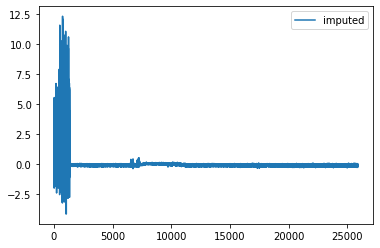

In [8]:
client1_flatten_data = all_client_data[2]
plt.plot(client1_flatten_data, label="imputed")
plt.legend()
plt.plot()

In [9]:
# Jiayu4: solve mulTS prediction results
"""Preprocess data"""
data = pd.read_csv('results/SSA_analysis/LD2011_2014_clean.txt', delimiter = ';')
#remove data before 2012
data = data.iloc[8760*4:]
print('Data loaded..')
data_2 = data.copy()
#pick the first 20 houses
data_2 = data_2.iloc[:,:]
# Aggregate
data_2['time'] =pd.to_datetime(data_2['Unnamed: 0']).dt.ceil('1h') 
data_2 = data_2.drop(['Unnamed: 0'], axis = 1)
agg_dict = {}
for col in data_2.columns[:-1]:
    agg_dict[col] ='mean'
aggregated_data = data_2.groupby(['time']).agg(agg_dict)
print('Data aggregated by hour')
aggregated_data.shape

Data loaded..
Data aggregated by hour


(26304, 370)

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
Std_normalization = 1
if Std_normalization:
    scaler = StandardScaler()
    temp = scaler.fit_transform(aggregated_data)
    norm_means = scaler.mean_
    norm_std = scaler.scale_
else:
    scaler = MinMaxScaler()
    temp = scaler.fit_transform(aggregated_data)
global data_4
normalized_data = pd.DataFrame(temp, index=aggregated_data.index, columns = aggregated_data.columns)

In [11]:
def set_train_test():
    data_train = normalized_data.iloc[:25968,:] #25600; 25968; 26082
    data_test = normalized_data.iloc[25968:,:]
    return data_train, data_test

In [12]:
data_train, data_test = set_train_test()
data_train.shape, data_test.shape

((25968, 370), (336, 370))

In [13]:
data_train = data_train.iloc[25968%80:,:] # second range, note its not T%L+1 due to python index
all_client_data = copy.deepcopy(data_train.values.T)

all_client_data.shape

(370, 25920)

In [14]:
def load_test_data():
  results_path = f"results/test_data/"
  file_name = f"test_data_336steps.npy"
  file_path = os.path.join(results_path, file_name)
  return_file = np.load(file_path)
  return return_file

In [15]:
from torch.utils.data import Dataset
import torch
# Create dataset
class timeseries(Dataset):
  def __init__(self, x, y):
    self.x = torch.Tensor(x)
    self.y = torch.Tensor(y)
    self.len = x.shape[0]
    # print(self.len)
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx] 
  
  def __len__(self):
    return self.len

In [16]:
train_data = copy.deepcopy(all_client_data)
train_data.shape

(370, 25920)

In [17]:
test_data = load_test_data()
test_data.shape

(370, 336)

In [18]:
# Define the test settings
window = 79
prediction_steps = 24
num_users = 370

In [19]:
# Get the last window of train data
last_window = train_data[:, -window:]

# Get actual data for prediction steps
# actual_steps = test_data[:, -prediction_steps:]
actual_steps = test_data[:, :prediction_steps] # Jiayu4: solve mulTS prediction results

last_window.shape, actual_steps.shape

((370, 79), (370, 24))

In [20]:
def create_np_data(user_test_data, prediction_steps=24):
    x_test = []
    y_test = []

    for i in range(prediction_steps):
        x_test.append(user_test_data[i:i+window])
        y_test.append(user_test_data[i+window])
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    return x_test, y_test

In [21]:
def load_model(model_name):
    model_path = os.path.join("models", "mulTS", "Imputed_Elec370", model_name + ".pt")
    assert (os.path.exists(model_path))
    model = torch.load(model_path)
    return model

In [22]:
model_name = f"FedLR_Imputed_Elec370_num_user_{n_users}_L_80_dim_40_MP_{missingVal}_W40"
model = load_model(model_name)
model

LR_nn(
  (hidden1): Linear(in_features=79, out_features=128, bias=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [23]:
model_name

'FedLR_Imputed_Elec370_num_user_37_L_80_dim_40_MP_20_W40'

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [25]:
import matplotlib.pyplot as plt
diff_list = []
y_pred = []
y_true = []
for user_id in range(num_users):
    user_last_window = last_window[user_id]
    user_actual_steps = actual_steps[user_id]
    user_test_data = np.concatenate((user_last_window, user_actual_steps), axis=None)
    # print(f"{user_last_window.shape}, {user_actual_steps.shape}, {user_test_data.shape}")

    """Create input data for data model"""
    # Create np data
    x_test, y_test = create_np_data(user_test_data=user_test_data, prediction_steps=prediction_steps)
    # Cretate dataset
    test_set = timeseries(x_test, y_test)
    # Prediction
    input = test_set[:][0]
    actual = test_set[:][1]
    input = input.to(device)
    test_pred = model(input)
    # print(test_pred.shape)
    predictions_24 = test_pred.cpu().detach().numpy()
    actual = actual.numpy()
    diff = predictions_24 - actual
    diff_list.append(diff)
    # plt.plot(predictions_24, label='predicted')
    # plt.plot(actual, label='original')
    # plt.legend()
    # plt.plot()
    # plt.show()
    # break
    y_pred.append(predictions_24)
    y_true.append(actual)
diff_np = np.array(diff_list)
rmse = np.sqrt(np.mean(np.square(diff_np)))
print(f"RMSE LSTM: {rmse}")

RMSE LSTM: 1.0006422996520996
